In [133]:
import pyemma.coordinates as coords
import pyemma.plots as mplt
import pyemma
import msmtools
import h5py
import mdtraj as md
import msmtools.estimation as est
import numpy as np
import pickle
import sklearn
import pyclustering
import matplotlib.pyplot as plt
import matplotlib
import sklearn.cluster as skc
import MSMRD.trajectories.trajectoryTools as trajectoryTools
from MSMRD.discretization import partitionSphere, plotPartitionedSphere
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
f = h5py.File('/srv/public/data/dibakma/MSMRD/myoglobin/tmp/CO_trajectories_aligned.h5')
fCA = h5py.File('/srv/public/data/dibakma/MSMRD/myoglobin/tmp/CA_trajectories_aligned.h5')
fHEM = h5py.File('/srv/public/data/dibakma/MSMRD/myoglobin/tmp/HEM_trajectories_aligned.h5')
trajs = 10.*np.array(f['coordinates']) #factor of ten to convert from nm to angstroem
trajsCA = 10.*np.array(fCA['coordinates'])
trajsHEM = 10.*np.array(fHEM['coordinates'])
f.close()
fCA.close()
fHEM.close()

In [113]:
davidsClusters = md.load('/srv/public/data/dibakma/MSMRD/myoglobin/myoWT-co_amber03_tip3p_cluster0.3_sorted.pdb').xyz*10 #factor of ten to convert to angstroem

In [4]:
#concatenated data, so the clustering algorithm can work with it
stride = 2
data = [trajs[::stride,i,:] for i in range(20)]
data = np.concatenate(data, axis=0)

In [5]:
print data.shape

(2500020, 3)


# SKIP from here on if you don't have at least 32 GB of RAM

In [6]:
#use density based clustering. Stride data by 10 otherwise we'll run out of memory
# Using full data:
# good: min: 500, eps: 0.5
# better: min:  600, eps:0.5
# Use stride of 2:
# min_samples=200, eps=0.33
db = skc.DBSCAN(min_samples=200, eps=0.33, n_jobs=4).fit(data)

In [7]:
#find number of centers found by density clustering
ncenters = np.amax(db.labels_)+1
print ncenters

16


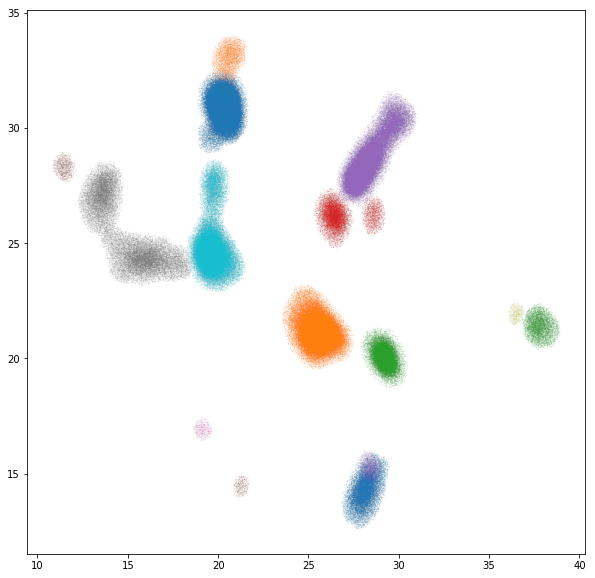

In [8]:
for i in range(ncenters):
    idcs=np.where(db.labels_==i)
    plt.scatter(data[idcs,0], data[idcs,1], s=0.001)

In [9]:
centers = []
for i in range(ncenters):
    idcs = np.where(db.labels_==i)[0]
    centers.append(np.mean(data[idcs], axis=0))

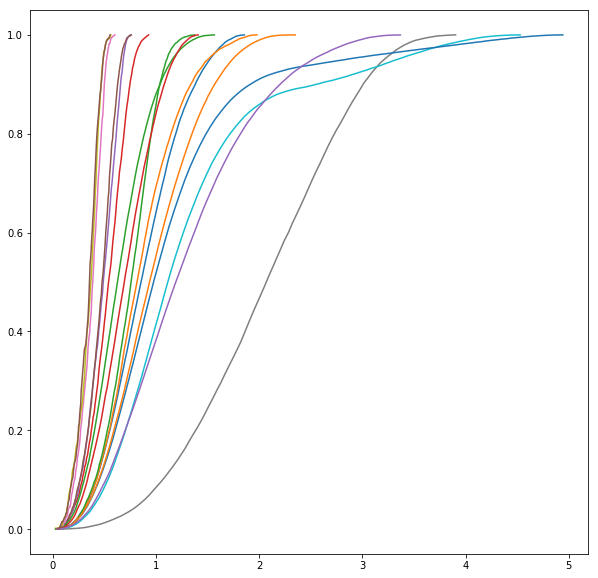

In [10]:
#find radius through histogram: radius is defined such that more than threshold of the assigned datapoints are in a sphere.
threshold = 0.8
radii = []
for i in range(ncenters):
    index = 4
    idcs = np.where(db.labels_== i)[0]
    dist = np.linalg.norm(data[idcs]-centers[i], axis=1)
    hist = np.histogram(dist, bins = 100, normed=True)
    binCenters = 0.5*(hist[1][1:]+hist[1][:-1])
    cs = np.cumsum(hist[0]*(hist[1][1]-hist[1][0]))
    plt.plot(binCenters, cs)
    radii.append(binCenters[np.where(cs >= threshold)[0][0]])

In [16]:
np.savetxt("/home/mi/dibakma/centers.dat", centers)

In [17]:
np.savetxt("/home/mi/dibakma/radii.dat", radii)

In [312]:
#pickle.dump([centers, radii], open('/group/ag_cmb/scratch/dibakma/MSMRD/myoglobin/centers_radii_DBSCAN_mins600_eps0.5.p', 'wa'))

# Skip until here!

In [11]:
#determine center of mass of the myoglobin CA atoms
com = np.mean(np.mean(trajsCA, axis=0), axis=0)
print com

[ 24.95029831  24.45178986  25.39104462]


In [12]:
#determine radius of myoglobine in order to estimate MSM radius
CAradius = 25.#np.amax(np.linalg.norm(trajsCA-com, axis=2))
print CAradius

25.0


In [13]:
for i in range(ncenters):
    for j in range(ncenters):
        if i!=j:
            d = np.linalg.norm(centers[i]-centers[j])
            if d < radii[i] + radii[j]:
                print 'overlap!', i, j

In [14]:
boxSize = 50
discretizer = trajectoryTools.trajDiscretization3DCython(np.array(centers, dtype=np.float64), boxSize, CAradius, np.array(com, dtype=np.float64), np.array(radii, dtype=np.float64))

In [15]:
dataList = [trajs[:,i,:].astype(np.float64) for i in range(20)]

In [16]:
%%time
dTrajs = []
truncTrajs = []
dTruncTrajs = []
for traj in dataList:
    dTrajs += discretizer.getdTrajs([traj])
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True) # Use True for code, false for traj plotting?
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)

CPU times: user 1min 29s, sys: 44 ms, total: 1min 29s
Wall time: 1min 29s


In [17]:
# Get exit/entry lookup tables
%time
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [18]:
#find exit trajectories
%time
exitTrajs = []
for i in range(ncenters):
    exitTrajs += (transitionTrajs[i][-1])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.86 µs


In [19]:
fullCount = est.count_matrix(dTrajs, 1, sparse_return=False)
exitCounts = est.count_matrix(exitTrajs, 1, sparse_return=False)

In [20]:
finalCountMatrix = 1. * fullCount[:-1,:-1]
for i in range(len(exitCounts)):
    finalCountMatrix[i,i] -= exitCounts[i,i]

# state 5 is not connected, so remove it

In [21]:
fM = np.copy(finalCountMatrix)
fM = np.delete(np.delete(fM, 5,1), 5, 0)
rC = np.copy(centers)
rC = np.delete(rC, 5, 0)
rR = np.copy(radii)
rR = np.delete(rR, 5, 0)

In [22]:
print rC
print centers
print rR, radii

[[ 28.11707497  14.27223492  35.41683578]
 [ 20.53772926  32.79758453  30.39629745]
 [ 37.78786469  21.39900589  15.20319653]
 [ 28.57013893  26.22614479  34.66653824]
 [ 28.37638855  15.31879044  19.07883453]
 [ 19.11572456  16.9292469   23.83207893]
 [ 14.98105812  25.42361641  30.78085136]
 [ 36.47937012  21.94994545  12.33651543]
 [ 19.66555214  24.88201332  24.92951012]
 [ 20.2912159   30.87698555  23.0815258 ]
 [ 25.51085854  21.17707253  31.30196762]
 [ 29.19034386  20.05918694  29.44808769]
 [ 26.37985229  26.16876221  26.27706909]
 [ 28.38989639  28.70209503  21.26355934]
 [ 21.25004959  14.47863102  34.72384262]]
[array([ 28.11707497,  14.27223492,  35.41683578], dtype=float32), array([ 20.53772926,  32.79758453,  30.39629745], dtype=float32), array([ 37.78786469,  21.39900589,  15.20319653], dtype=float32), array([ 28.57013893,  26.22614479,  34.66653824], dtype=float32), array([ 28.37638855,  15.31879044,  19.07883453], dtype=float32), array([ 11.43845558,  28.30264473,  15

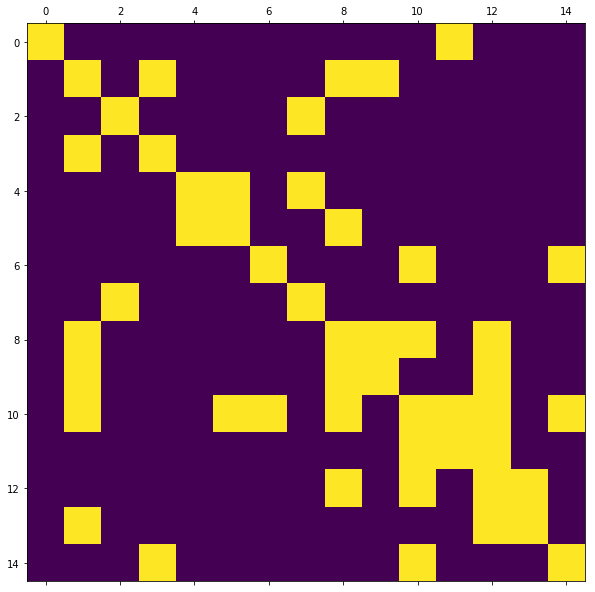

In [23]:
plt.matshow(fM !=0)

In [24]:
tmatrix = est.transition_matrix(fM, reversible=False)
print msmtools.estimation.largest_connected_submatrix(tmatrix).shape
print tmatrix.shape

(12, 12)
(15, 15)


In [25]:
# get the largest connected set
lcs = msmtools.estimation.largest_connected_set(tmatrix)

In [125]:
print lcs, len(lcs), len(centers)

[ 1  3  4  5  6  8  9 10 11 12 13 14] 12 16


In [27]:
# remove isolated states that are not part of the largest connected set
cleanedCenters = np.array([rC[i] for i in lcs])
cleanedRadii = np.array([rR[i] for i in lcs])

In [58]:
# plot found centers in order to identify the bound state.
# Spoiler alert: it is state 10

In [28]:
#use 2D histogram for vizualisation
X = np.arange(-20, 70, 0.1)
Y = np.arange(-20, 70, 0.1)
Zxy = np.zeros([X.shape[0]-1, X.shape[0]-1])
Zxz = np.zeros([X.shape[0]-1, X.shape[0]-1])
Zyz = np.zeros([X.shape[0]-1, X.shape[0]-1])
for i in range(20):
    histxy = np.histogram2d(trajs[:,i,0], trajs[:,i,1], bins = [X, Y], normed=False)
    histxz = np.histogram2d(trajs[:,i,0], trajs[:,i,2], bins = [X, Y], normed=False)
    histyz = np.histogram2d(trajs[:,i,1], trajs[:,i,2], bins = [X, Y], normed=False)
    Zxy += histxy[0]
    Zxz += histxz[0]
    Zyz += histyz[0]
histxyHEM = np.histogram2d(np.mean(trajsHEM, axis=1)[0], np.mean(trajsHEM, axis=1)[1], bins = [X,Y])
extent = [X[0], X[-1], Y[0], Y[-1]]

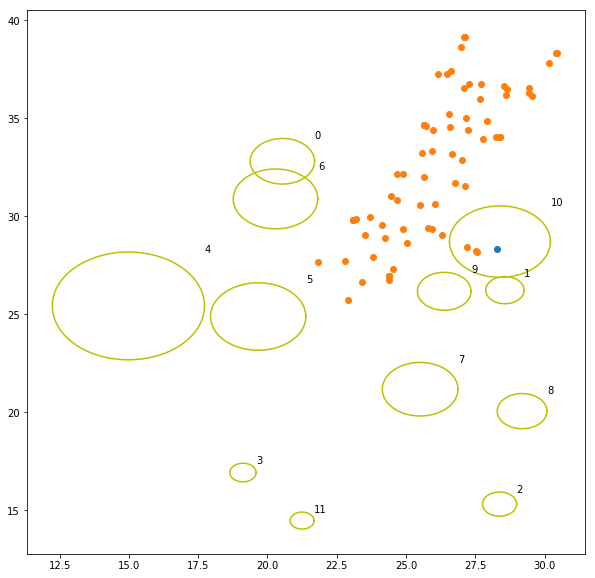

In [29]:
meanPos=np.mean(trajsHEM, axis=0)
alphas = np.arange(0., 2*np.pi, 0.01)
cos = np.cos(alphas)
sin = np.sin(alphas)
plt.scatter(davidsClusters[0][:1,0], davidsClusters[0][:1,1])
for i in range(len(lcs)):
    plt.plot(cleanedRadii[i]*cos + cleanedCenters[i][0], cleanedRadii[i]*sin+cleanedCenters[i][1], 'y-')
    plt.text(cleanedCenters[i][0]+cleanedRadii[i], cleanedCenters[i][1]+cleanedRadii[i], str(i), color='k')
plt.scatter(meanPos[:,0], meanPos[:,1])

In [119]:
print np.linalg.norm(cleanedCenters-davidsClusters[0][0], axis=1)

[ 13.01628304  13.90126038  13.15249062  14.92016411  16.80495262
  10.10754585   8.65367222  12.90555668  11.91462994   6.07585239
   0.50443172  20.78046799]


In [118]:
print davidsClusters[0][0]

[ 28.28000069  28.34000015  20.93000031]


In [30]:
boxSize = 50
lcsDiscretizer = trajectoryTools.trajDiscretization3DCython(np.array(cleanedCenters, dtype=np.float64), boxSize, CAradius, np.array(com, dtype=np.float64), np.array(cleanedRadii, dtype=np.float64))

In [31]:
%%time
dTrajsLcs = []
truncTrajsLcs = []
dTruncTrajsLcs = []
for traj in dataList:
    dTrajsLcs += lcsDiscretizer.getdTrajs([traj])
    lastTruncTrajsLcs = lcsDiscretizer.getTruncatedTraj(traj, prepend=True) # Use True for code, false for traj plotting?
    truncTrajsLcs += lastTruncTrajsLcs
    dTruncTrajsLcs += lcsDiscretizer.getdTrajs(lastTruncTrajsLcs)
# Get exit/entry lookup tables
# CALL WITH dTruncTrajs or dTrajs, see function in trajectoryTools.pyx
entryTrajsStartLcs, entryTrajsEndLcs, entryTimesLcs = lcsDiscretizer.getLookupTableEntry(dTruncTrajsLcs, truncTrajsLcs)
exitPositionsLcs, exitTimesLcs = lcsDiscretizer.getLookupTableExit(dTruncTrajsLcs, truncTrajsLcs)
transitionTrajsLcs = lcsDiscretizer.getTransitionTrajs(dTruncTrajsLcs)
#find exit trajectories
exitTrajsLcs = []
for i in range(len(lcs)):
    exitTrajsLcs += (transitionTrajsLcs[i][-1])

CPU times: user 1min 13s, sys: 48 ms, total: 1min 13s
Wall time: 1min 13s


# revert periodic boundary conditions in the truncated trajs

In [33]:
# Copy previous trunc trajs so we don't mess with the original data
truncTrajsCopy = []
for trTraj in truncTrajsLcs:
    truncTrajsCopy.append(np.copy(trTraj))

fix periodicity in enter and exit step (this is where the majority of the jumps occur)

In [34]:
# if there is a jump at the beginning or the end of the trajectory, we  can fix that
# quite easily by just mapping the particle back in the box.
# This affects roughly 25 % of the trajectories
# IMPORTANT: due to the rotation of the molecule we do not know where the boundary is.
# Therefore we just do a step in the last direction with step length 50. This is just an approximation.
boxSize = 50
fixedTruncTrajs1 = []
for trTraj in truncTrajsCopy:
    increments = trTraj[1:] - trTraj[:-1]
    jl = np.linalg.norm(increments, axis=1)
    jind = np.where(np.logical_and(jl>40, jl < 60))[0] #these are the jumps around one box 
    if jind.size != 0:
        #fix entry jumps
        if jind[0] == 0:
            oldRad = np.linalg.norm(trTraj[0]-com) #ensure to have the same distance from center
            unitvec = increments[0] / np.linalg.norm(increments[0])
            trTraj[0] += boxSize*unitvec
            # Due to the box wrapping the particle might be suddenly in the box. We have to revert that!
            dCenter = np.linalg.norm(trTraj[0]-com)
            if dCenter < CAradius:
                trTraj[0] = oldRad*(trTraj[0]-com)/dCenter + com
        #fix exit jumps:
        if jind[-1] == len(trTraj)-2:
            oldRad = np.linalg.norm(trTraj[-1]-com)
            unitvec = increments[-1] / np.linalg.norm(increments[-1])
            trTraj[-1] -= 1.01*boxSize*unitvec
            dCenter = np.linalg.norm(trTraj[-1]-com)
            if dCenter < CAradius:
                trTraj[-1] = oldRad*(trTraj[-1]-com)/dCenter + com
    fixedTruncTrajs1.append(trTraj)

In [78]:
# if there is a jump at the beginning or the end of the trajectory, we  can fix that
# quite easily by just mapping the particle back in the box.
# This affects roughly 25 % of the trajectories
# IMPORTANT: due to the rotation of the molecule we do not know where the boundary is.
# Therefore we just do a step in the last direction with step length 50. This is just an approximation.
# Same as above but as a function
def fixTruncTrajs1(tTrajs):
    boxSize = 50
    fixedTruncTrajs1 = []
    for trTraj in tTrajs:
        increments = trTraj[1:] - trTraj[:-1]
        jl = np.linalg.norm(increments, axis=1)
        jind = np.where(np.logical_and(jl>40, jl < 60))[0] #these are the jumps around one box 
        if jind.size != 0:
            #fix entry jumps
            if jind[0] == 0:
                oldRad = np.linalg.norm(trTraj[0]-com) #ensure to have the same distance from center
                unitvec = increments[0] / np.linalg.norm(increments[0])
                trTraj[0] += boxSize*unitvec
                # Due to the box wrapping the particle might be suddenly in the box. We have to revert that!
                dCenter = np.linalg.norm(trTraj[0]-com)
                if dCenter < CAradius:
                    trTraj[0] = oldRad*(trTraj[0]-com)/dCenter + com
            #fix exit jumps:
            if jind[-1] == len(trTraj)-2:
                oldRad = np.linalg.norm(trTraj[-1]-com)
                unitvec = increments[-1] / np.linalg.norm(increments[-1])
                trTraj[-1] -= 1.01*boxSize*unitvec
                dCenter = np.linalg.norm(trTraj[-1]-com)
                if dCenter < CAradius:
                    trTraj[-1] = oldRad*(trTraj[-1]-com)/dCenter + com
        fixedTruncTrajs1.append(trTraj)
    return fixedTruncTrajs1

fix periodicity when it occurs in the middle of a trajectory. This is done by splitting the trajectory whenever there is a jump. Resulting in more exit trajectories

In [35]:
boxSize = 50
fixedTruncTrajs2 = []
for N, trTraj in enumerate(fixedTruncTrajs1):
    increments = trTraj[1:] - trTraj[:-1]
    jind = np.where(np.linalg.norm(increments, axis=1)>40)[0]
    lastJump = 0
    if jind.size != 0:
        #split trajectory
        for i, jump in enumerate(jind):
            traj = np.copy(trTraj[lastJump:jump+1])
            newEnd = np.copy(trTraj[jump+1])
            unitvec = increments[jump] / np.linalg.norm(increments[jump])
            newEnd -= boxSize*unitvec
            #newEnd += boxSize*(increments[jump]<-30)
            fixedTruncTrajs2.append(np.concatenate((traj, [newEnd])))
            newStart = trTraj[jump]
            newStart += boxSize*unitvec
            #newStart -= boxSize*(increments[jump]<-30)
            trTraj[jump] = newStart
            lastJump = jump
    fixedTruncTrajs2.append(trTraj[lastJump:])

In [79]:
# Same as above but as a function
def fixTruncTrajs2(tTrajs):
    boxSize = 50
    fixedTruncTrajs2 = []
    for N, trTraj in enumerate(tTrajs):
        increments = trTraj[1:] - trTraj[:-1]
        jind = np.where(np.linalg.norm(increments, axis=1)>40)[0]
        lastJump = 0
        if jind.size != 0:
            #split trajectory
            for i, jump in enumerate(jind):
                traj = np.copy(trTraj[lastJump:jump+1])
                newEnd = np.copy(trTraj[jump+1])
                unitvec = increments[jump] / np.linalg.norm(increments[jump])
                newEnd -= boxSize*unitvec
                #newEnd += boxSize*(increments[jump]<-30)
                fixedTruncTrajs2.append(np.concatenate((traj, [newEnd])))
                newStart = trTraj[jump]
                newStart += boxSize*unitvec
                #newStart -= boxSize*(increments[jump]<-30)
                trTraj[jump] = newStart
                lastJump = jump
        fixedTruncTrajs2.append(trTraj[lastJump:])
    return fixedTruncTrajs2

In [37]:
# Check if there are any jumps left in the trajectories
counter = 0
totalCounts = 0
jumped = []
jindices = []
lengths = []
totLengths = []
Njumps = []
for trTraj in fixedTruncTrajs2:#truncTrajsLcs:
    totalCounts += 1
    jumps = trTraj[1:] - trTraj[:-1]
    jind = np.where(np.linalg.norm(jumps, axis=1)>20)[0]
    totLengths.append(len(trTraj))
    if jind.size != 0:
        jindices.append(len(jumps)-2 == jind[-1] or jind[-1] == 0)
        if not (len(jumps)-1 == jind[-1] or jind[-1] == 0):
            lengths.append(len(trTraj))
        counter += 1
        Njumps.append(len(jind))
        jumped.append(trTraj)
print counter

0


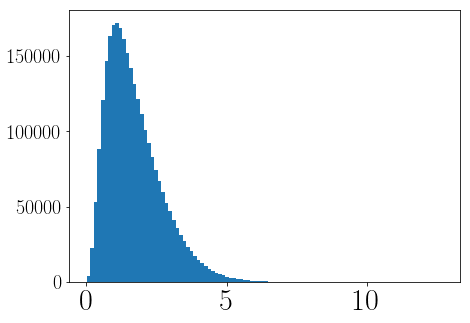

In [189]:
# Check the increments as well
increments = []
for trTraj in fixedTruncTrajs2:
    inc = trTraj[1:] - trTraj[:-1]
    increments += [i for i in np.linalg.norm(inc, axis=1)]
plt.hist(increments, bins=100);
#plt.xlim((0,10))

In [194]:
np.where(np.array(increments) > 10)

(array([ 317992,  331734,  425866,  425936,  425973,  547347,  547396,
         949196,  949197,  949198, 1096588, 1215629, 1663391, 1670477,
        2129139, 2152272, 2286434, 2409019, 2557216, 2685363, 2685858,
        2685878, 2685879]),)

## Recompute exit and transition trajectories

In [38]:
%%time
dTruncTrajsFixed = lcsDiscretizer.getdTrajs(fixedTruncTrajs2)

CPU times: user 33.7 s, sys: 48 ms, total: 33.7 s
Wall time: 33.6 s


In [40]:
# check for illegal states (smaller than 0)
for i, dt in enumerate(dTruncTrajsFixed):
    if np.any(dt < 0):
        print 'found one', i, dt
        break

In [41]:
entryTrajsStartFixed, entryTrajsEndFixed, entryTimesFixed = lcsDiscretizer.getLookupTableEntry(dTruncTrajsFixed, fixedTruncTrajs2)
exitPositionsFixed, exitTimesFixed = lcsDiscretizer.getLookupTableExit(dTruncTrajsFixed, fixedTruncTrajs2)
transitionTrajsFixed = lcsDiscretizer.getTransitionTrajs(dTruncTrajsFixed)
#find exit trajectories
exitTrajsFixed = []
for i in range(len(lcs)):
    exitTrajsFixed += (transitionTrajsFixed[i][-1])

In [61]:
transitionTrajs2 = lcsDiscretizer.getTransitionTrajs(dTrajsLcs)

In [42]:
# Calculate exit probabilities for each of the inner states
exitProbsFixed = np.zeros(len(lcs))
for i in range(len(lcs)):
    outgoingTrajsFixed = 0
    for j in range(len(lcs)+1): # all states including the bath state!
        outgoingTrajsFixed += len(transitionTrajsFixed[i][j])   
    exitProbsFixed[i] = len(transitionTrajsFixed[i][len(lcs)])/float(outgoingTrajsFixed)
print exitProbsFixed

[ 0.68571429  0.97560976  0.96774194  0.93023256  0.73684211  0.01459854
  0.          0.00381679  0.          0.          0.012       0.        ]


# Check timescales

In [90]:
#prepare discretized trajectories so they don't have to be recomputed in every iteration of the implied timescale computation.
#%%time
truncatedTrajsFixed = []
dTruncatedTrajsFixed = []
for traj in dataList:
    #truncatedTrajs.append(lcsDiscretizer.getTruncatedTraj(traj, prepend=True))
    trTrajs = lcsDiscretizer.getTruncatedTraj(traj, prepend=True)
    trTrajsF1 = fixTruncTrajs1(trTrajs)
    trTrajsF2 = fixTruncTrajs2(trTrajsF1)
    truncatedTrajsFixed.append(trTrajsF2)
dTruncatedTrajsFixed = [lcsDiscretizer.getdTrajs(trTraj) for trTraj in truncatedTrajsFixed]

In [91]:
truncatedTrajs = np.copy(truncatedTrajsFixed)
dTruncatedTrajs = np.copy(dTruncatedTrajsFixed)

In [92]:
def implied_timescales_resampling(lag, nsamples):
    samples = []
    trajectories = 20
    impliedTimescales = []
    for i in range(nsamples):
        sampleIndices = np.random.choice(trajectories, size=trajectories, replace=True)
        sample = [dTrajsLcs[j] for j in sampleIndices]
        sampleTrTrajs = []
        for j in range(trajectories):
            sampleTrTrajs += dTruncatedTrajs[sampleIndices[j]]
        transitionTrajSample = lcsDiscretizer.getTransitionTrajs(sampleTrTrajs)
        exitTrajsSample = []
        for j in range(len(lcs)):
            exitTrajsSample += (transitionTrajSample[j][-1])
        fullCount = est.count_matrix(sample, lag, sliding=True, sparse_return=False)
        exitCounts = est.count_matrix(exitTrajsSample, lag, sliding=True, sparse_return=False)
        finalCountMatrix = 1. * np.asarray(fullCount)
        for j in range(exitCounts.shape[0]):
            finalCountMatrix[j,j] -= exitCounts[j,j]
        if np.any(finalCountMatrix < 0):
            print 'negative entry in final count Matrix'
            return fullCount, exitCounts
        if np.any(np.sum(finalCountMatrix[:-1,:-1], axis=1) == 0):
            print 'skipped sample due to sum being zero before estimation'
            continue
        tmatrix = np.asarray(est.transition_matrix(finalCountMatrix[:-1,:-1], reversible=False))
        if np.any(tmatrix < 0):
            print 'negative entry in tmatrix'
        internalTmatrix = np.copy(tmatrix).astype('float64')
        if np.any(np.sum(internalTmatrix, axis=1) == 0):
            print 'skipped sample due to sum being zero'
            continue
        if np.any(internalTmatrix < 0):
            print 'negative entry in internal tmatrix'
        #for j in range(len(internalTmatrix)):
        #    internalTmatrix[j,:] /= np.sum(internalTmatrix[j,:])
        try:
            assert np.allclose(np.sum(internalTmatrix, axis=1), 1)
        except:
            print 'assertion failed' + str(i)
            return internalTmatrix
        if not est.is_connected(internalTmatrix):
            print 'skipped sample as is not connected'
            continue
        try:
            msm = pyemma.msm.markov_model(internalTmatrix, dt_model=str(lag) + ' step')
        except:
            print 'not a T matrix'
            print np.any(internalTmatrix < 0)
            return internalTmatrix
        impliedTimescales.append(msm.timescales())
    return np.array(impliedTimescales)

In [43]:
def implied_timescales(d_trajs, exit_trajs, lag):
    fullCount = est.count_matrix(d_trajs, lag)
    exitCounts = est.count_matrix(exit_trajs, lag)
    finalCountMatrix = 1. * fullCount
    for i in range(exitCounts.shape[0]):
        finalCountMatrix[i,i] -= exitCounts[i,i]
    tmatrixFull = est.transition_matrix(fullCount)
    tmatrix = est.transition_matrix(est.largest_connected_submatrix(finalCountMatrix[:-1,:-1]), reversible=False).todense()
    MSM = pyemma.msm.markov_model(np.asarray(tmatrix))
    return MSM.timescales()*lag

In [138]:
print nsamples

[129, 137, 137, 119, 143, 189, 219, 224, 194, 202]


In [137]:
lags = []
timescales = []
errors = []
nsamples = []
for lag in range(1, 200, 20):
    print lag
    its = implied_timescales_resampling(lag, 1000)
    timescales.append(np.mean(its, axis=0))
    errors.append(np.std(its, axis=0))
    lags.append(lag)
    nsamples.append(len(its))

1
skipped sample due to sum being zero before estimation
skipped sample as is not connected
skipped sample due to sum being zero before estimation
skipped sample as is not connected
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample as is not connected
skipped sample due to sum being zero before estimation
skipped sample as is not connected
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample as is not connected
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample as is not connected
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample due to sum being zero before estimation
skipped sample due

In [139]:
impliedTimescalesList = [2*np.array(lagtimes), 2*np.array(timescalesTrue), 2*np.array(lags), 2*np.array(timescales), 2*np.array(errors), nsamples]
pickle.dump(impliedTimescalesList, open('/group/ag_cmb/scratch/dibakma/MSMRD/models/myoglobin/impliedTimescalesEps0.33MinS200_fixed_1000runs.p', 'wa'))

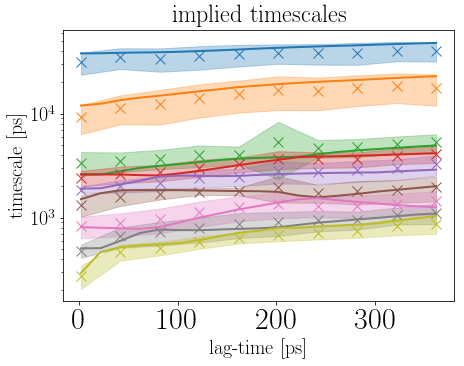

In [141]:
# Do the actual plot with proper timescaling
matplotlib.rcParams.update({'ytick.labelsize':24, 'xtick.labelsize':24, 'axes.labelsize':24, 'axes.titlesize':26})
plt.style.use('paperPlot')
plt.rcParams['figure.figsize'] = (7, 5)
scale = 2
lagtimes = np.array(lagtimes)
for i in range(len(lcs)-3):
    plt.plot(2*np.array(lagtimes)[:-1], 2*np.array(timescalesTrue)[:-1,i], c='C'+str(i%9))
    plt.plot(2*np.array(lags), 2*np.array(timescales)[:,i], 'x', c='C'+str(i%9))
    plt.fill_between(2*np.array(lags), 2*np.array(timescales)[:,i]+2*np.array(errors)[:,i], 2*np.array(timescales)[:,i]-2*np.array(errors)[:,i], alpha=0.3, color='C'+str(i%9))
plt.xlabel('lag-time [ps]')
plt.ylabel('timescale [ps]')
plt.title('implied timescales')
plt.yscale('log')
plt.savefig('../Paper/figs/myoglobin/impliedTimescales_myoglobin_pbc.pdf', bbox_inches='tight')

In [96]:
print nsamples

[55, 51, 70, 59, 60, 110, 102, 99, 87, 104]


In [44]:
timescalesTrue = []
lagtimes = range(1, 200, 10)
for lag in lagtimes:
    tsc = implied_timescales(dTrajsLcs, exitTrajsFixed,lag)[:11]
    timescalesTrue.append(tsc)

/home/mi/dibakma/miniconda2/lib/python2.7/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [109]:
print np.array(timescales)[:,0], np.array(errors)[:,0], impliedTimescales[:,0]

 [ 16665.59617202  16502.67552257  17109.7419263   17546.5208723
  19355.53648373  18617.7254427   18880.18205926  19499.38697621
  19958.52610736  21877.57053821] [ 3590.29419768  3868.36787429  3885.31984529  3984.16455165  4300.28418786
  4067.1682053   3906.09126949  4175.16335524  4552.9330906   5068.50574303] [ 19036.30259272  19093.04532619  19294.05729061  19423.95770152
  19530.03882806  19728.14236447  20070.35386948  20370.73529015
  20750.63132578  21168.97762856  21542.0475221   21892.11661345
  22212.74897625  22494.67594462  22763.76903685  23112.0579616
  23429.24588982  23728.05261909  23990.1403978   24186.82190888]


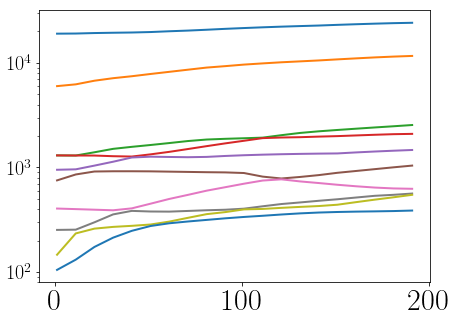

In [134]:
plt.rcParams['figure.figsize'] = (7, 5)
impliedTimescales = np.array(timescalesTrue)
ncenters = 11
timescalesTrue = np.array(timescalesTrue)
for i in range(ncenters-1):
    plt.plot(lagtimes, impliedTimescales[:,i], c='C'+str(i%9))
#plt.fill_between(np.array(lags), np.array(timescales)[:,i]+np.array(errors)[:,i], np.array(timescales)[:,i]-np.array(errors)[:,i], alpha=0.3, color='C'+str(i%9))
plt.yscale('log')

In [46]:
selectedLag = 75
fullCount = est.count_matrix(dTrajsLcs, selectedLag, sparse_return=False)
exitCounts = est.count_matrix(exitTrajsLcs, selectedLag, sparse_return=False)

In [47]:
finalCountMatrix = 1. * fullCount[:-1,:-1]
for i in range(len(exitCounts)):
    finalCountMatrix[i,i] -= exitCounts[i,i]

In [48]:
tmatrixLcs = est.transition_matrix(finalCountMatrix, reversible=False)

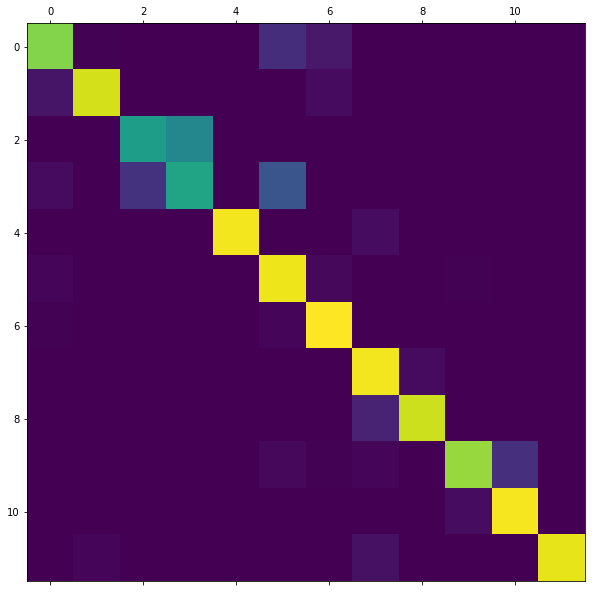

In [49]:
plt.matshow(tmatrixLcs)

In [50]:
entryTrajsStart = entryTrajsStartFixed
entryTrajsEnd = entryTrajsEndFixed
entryTimes = entryTimesFixed
exitTrajs = exitTrajsFixed
exitTimes = exitTimesFixed
exitProbs = exitProbsFixed
exitPositions = exitPositionsFixed

In [51]:
# Express all coordnates in the com of the myoglobin
entryTrajsStartShifted = entryTrajsStart - com
entryTrajsEndShifted = []
for i in range(len(entryTrajsEnd)):
    entryTrajsEndShifted.append(entryTrajsEnd[i]-com if isinstance(entryTrajsEnd[i], np.ndarray) else entryTrajsEnd[i])
exitPositionsShifted = [[exitPosition-com for exitPosition in exitPositions[i]] for i in range(len(exitPositions))]

In [52]:
# Partition MSM entry trajectories into discrete regions in the sphere 
numPartitions=240
spherePartitionsForLookUp = 1*numPartitions
regionsPerCollar2, phis2, thetas2 = partitionSphere(spherePartitionsForLookUp)
thetas_coord = np.arctan2(entryTrajsStartShifted[:,1], entryTrajsStartShifted[:,0])
thetas_coord[thetas_coord<0] = thetas_coord[thetas_coord<0] + 2*np.pi
r = np.linalg.norm(entryTrajsStartShifted[:], axis=1)
phis_coords = np.arccos(entryTrajsStartShifted[:,2]/r)
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(len(regionsPerCollar2)):
    phiIncrement = np.pi/len(regionsPerCollar2)
    idcs_phi = np.where(np.logical_and(phis_coords>i*phiIncrement, phis_coords<= (i+1)*phiIncrement))[0]
    for j in range(regionsPerCollar2[i]):
        thetaIncrement = 2*np.pi/regionsPerCollar2[i]
        idcs_theta = np.where(np.logical_and(thetas_coord>j*thetaIncrement, thetas_coord<= (j+1)*thetaIncrement))[0]
        idcs = np.intersect1d(idcs_phi,idcs_theta)
        sortedEntryTrajsStart.append(entryTrajsStartShifted[idcs])
        sortedEntryTimes.append(entryTimes[idcs])
        sortedEnds = []
        for j in idcs:
            sortedEnds.append(entryTrajsEndShifted[j])
        sortedEntryTrajsEnd.append(sortedEnds)

In [53]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModelMyoglobin(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, numPartitions, interactionRadius, TStimestep, description=None):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.numPartitions = numPartitions
        self.interactionRadius = interactionRadius
        self.TStimestep = TStimestep
        self.description = description

In [55]:
description = 'time units is 2 pico seconds, length units are angstroem.  \
State index 10 is the geminated state (binding site) of the CO in the myoglobin. Discretization was done using DBSCAN with stride:2 min:200, eps:0.33. \
Lag is 75 timestep which corresponds to 150 ps. Jumps in the trajectories were fixed at the end and beginning and the middle as well'
model = truncTrajsModelMyoglobin(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositionsShifted, exitTimes, exitProbsFixed, 150., tmatrixLcs, numPartitions, CAradius, 2., description)

In [56]:
pickle.dump(model, open('/group/ag_cmb/scratch/dibakma/MSMRD/models/myoglobin/myoglobin_lag150_240partitions_min200_eps0.33_lcs_rad25_fixed.p', 'wa'))